In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [47]:
import csv
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from typing import Iterator, List, Callable, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [48]:
root_path = 'gdrive/MyDrive/Colab Notebooks/tema1-deeplearning/'

In [49]:
f = open(root_path + 'pmi-data.csv')
datareader = csv.reader(f)
f.close

headers = []
headers = next(datareader)
print(headers)
rows = []
for row in datareader:
  rows.append([float(el) for el in row])
print(rows)

['', 'id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
[[0.0, 9046.0, 2.0, 67.0, 0.0, 1.0, 1.0, 4.0, 0.0, 228.69, 36.6, 1.0, 1.0], [1.0, 51676.0, 1.0, 61.0, 0.0, 0.0, 1.0, 3.0, 1.0, 202.21, 29.1, 2.0, 1.0], [2.0, 31112.0, 2.0, 80.0, 0.0, 1.0, 1.0, 4.0, 1.0, 105.92, 32.5, 2.0, 1.0], [3.0, 60182.0, 1.0, 49.0, 0.0, 0.0, 1.0, 4.0, 0.0, 171.23, 34.4, 0.0, 1.0], [4.0, 1665.0, 1.0, 79.0, 1.0, 0.0, 1.0, 3.0, 1.0, 174.12, 24.0, 2.0, 1.0], [5.0, 56669.0, 2.0, 81.0, 0.0, 0.0, 1.0, 4.0, 0.0, 186.21, 29.0, 1.0, 1.0], [6.0, 53882.0, 2.0, 74.0, 1.0, 1.0, 1.0, 4.0, 1.0, 70.09, 27.4, 2.0, 1.0], [7.0, 10434.0, 1.0, 69.0, 0.0, 0.0, 0.0, 4.0, 0.0, 94.39, 22.8, 2.0, 1.0], [10.0, 12109.0, 1.0, 81.0, 1.0, 0.0, 1.0, 4.0, 1.0, 80.43, 29.7, 2.0, 1.0], [11.0, 12095.0, 1.0, 61.0, 0.0, 1.0, 1.0, 2.0, 1.0, 120.46, 36.8, 0.0, 1.0], [12.0, 12175.0, 1.0, 54.0, 0.0, 0.0, 1.0, 4.0, 0.0, 104.51, 27.3, 0.0, 1.0], [

Odata colectate datele din .csv, urmatorul pas este sa separam label-urile (ultima coloana din fisier) de datele propriu-zise. Dupa ce am facut separarea, urmeaza sa impartim setul de date in train si validation, folosind train_test_split, setul de validare fiind 20% din setul initial. Impartirea datelor este un principiu de baza in machine learning, deoarece atunci cand vom atrena un model care sa poata clasifica datele, dorim sa vedem daca am reusit sa il antrenam bine. Astfel il vom verifica pe un set de date diferit de cel de antrenare, pentru a evita overfitting-ul. De asemenea, odata cu impartirea datelor aplic si un shuffle, evitand situatia cand datele sunt date intr-o ordine specifica care poate afecta clasificatorul nostru odata cu impartirea in train si validation (spre exemplu primele 50% de exemple sunt dintr-o clasa, iar urmatoarele din cealalta clasa).

In [50]:
data_rows = [patient_data[2:12] for patient_data in rows]
data_labels = [patient_data[12] for patient_data in rows]
train_data, validation_data, train_labels, validation_labels = train_test_split(data_rows, data_labels, test_size=0.2, random_state=42)

# Dataset and Dataloader

In [51]:
class StrokeDataset(Dataset):
  def __init__(self, patient_data, patient_labels, transform=None):
    self.data = patient_data
    self.label = patient_labels

  def __getitem__(self, idx):
    patient_data = self.data[idx]
    patient_label = self.label[idx]

    patient_data_tensor = torch.tensor(patient_data)
    patient_label_tensor = torch.tensor([patient_label])
    return patient_data_tensor, patient_label_tensor

  def __len__(self):
    return len(self.data)

In [52]:
train_dataset = StrokeDataset(patient_data=train_data, patient_labels=train_labels)
validation_dataset = StrokeDataset(patient_data=validation_data, patient_labels=validation_labels)
print(len(validation_dataset))

714


In [53]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=64, shuffle=True)

# Creating the model

In [54]:
class StrokeClassificator(nn.Module):
  def __init__(self, 
                 input_size: int, 
                 hidden_size_1: int, 
                 hidden_size_2: int,
                 activation_fn: Callable):
    super().__init__()
    self.input_size = input_size
    self.hidden_size_1 = hidden_size_1
    self.hidden_size_2 = hidden_size_2
    self.layer_1 = nn.Linear(input_size, hidden_size_1)
    self.layer_2 = nn.Linear(hidden_size_1, hidden_size_2)
    self.output_layer = nn.Linear(hidden_size_2, 1)
    self.activation_fn = activation_fn

  def forward(self, x):
    h1 = self.activation_fn(self.layer_1(x))
    h2 = self.activation_fn(self.layer_2(h1))
    out = self.output_layer(h2)

    return out

Un exemplu de definire a modelului creat anterior

In [55]:
model = StrokeClassificator(
    input_size=10,
    hidden_size_1=768,
    hidden_size_2=512,
    activation_fn=nn.ReLU()
)
print("Model's parameters: ")
for param in model.parameters():
  print(param)

Model's parameters: 
Parameter containing:
tensor([[-0.1393,  0.2167, -0.0363,  ...,  0.2756,  0.1492, -0.0402],
        [ 0.0824,  0.2050, -0.2172,  ..., -0.1543, -0.2102,  0.0190],
        [ 0.2958, -0.1087, -0.0529,  ..., -0.0023, -0.1270, -0.1273],
        ...,
        [-0.0959, -0.0768, -0.0749,  ..., -0.2587, -0.0481,  0.1000],
        [ 0.3115, -0.1808, -0.1796,  ..., -0.3064,  0.2853,  0.0650],
        [ 0.2182,  0.1338,  0.0041,  ..., -0.0663, -0.0065,  0.1120]],
       requires_grad=True)
Parameter containing:
tensor([ 2.2782e-01, -3.9090e-02, -2.4163e-01,  1.4740e-01,  3.3135e-02,
        -2.0988e-01,  1.0761e-01,  1.2496e-01,  5.5422e-02, -1.3752e-01,
        -1.2106e-01, -8.2692e-02,  1.6666e-01, -6.9830e-03,  2.5593e-01,
        -3.0364e-01,  2.7247e-01, -2.6755e-01,  2.0562e-01,  2.3633e-01,
        -1.2973e-01, -2.7748e-01,  1.7233e-01,  2.7176e-01,  1.1656e-01,
         2.7201e-01, -4.5529e-03,  5.6949e-03, -2.3238e-01,  2.3161e-01,
         3.3949e-02,  2.0113e-02,  5

# Training and evaluation

In [56]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device):
    """
    model: Model object 
    train_dataloader: DataLoader over the training dataset
    loss_crt: loss function object
    optimizer: Optimizer object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch training loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels 
    """
    model.train()
    epoch_loss = 0.0
    num_batches = len(train_dataloader)
    predictions = []
    labels = []
    for idx, batch in tqdm(enumerate(train_dataloader)):
        # batch_size x 10, batch_size x 1
        batch_data, batch_labels = batch
        current_batch_size = batch_data.size(0)

        # move data to GPU
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        output = model(batch_data)
        # deoarece am doar un layer de output pentru o clasificare binara, voi normaliza datele folosind sigmoid (ele vor fi aduse in intervalul [0,1])
        m = nn.Sigmoid()
        # daca in urma normalizarii valoarea este mai mare decat 0.5 atunci consider ca este stroke
        batch_predictions = torch.round(m(output.squeeze()))
        
        predictions += batch_predictions.tolist()
        labels += batch_labels.squeeze().tolist()

        loss = loss_crt(output, batch_labels)
        loss_scalar = loss.item()
        # print("  epoch %d, batch %d/%d, loss=%f" % (
        #     epoch_idx, idx, num_batches, loss_scalar
        # ))

        loss.backward()

        optimizer.step()
        model.zero_grad()

        epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

def eval_epoch(model, val_dataloader, loss_crt, device):
    """
    model: Model object 
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch validation loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels 
    """
    model.eval()
    epoch_loss = 0.0
    num_batches = len(val_dataloader)
    predictions = []
    labels = []
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(val_dataloader)):
            # batch_size x 10, batch_size x 1
            batch_data, batch_labels = batch
            current_batch_size = batch_data.size(0)

            # move data to GPU
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            output = model(batch_data)

            m = nn.Sigmoid()
            batch_predictions = torch.round(m(output.squeeze()))
        
            predictions += batch_predictions.tolist()
            labels += batch_labels.squeeze().tolist()

            loss = loss_crt(output, batch_labels)
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

In [57]:
def compute_accuracy(predictions: List[int], labels:List[int]) -> float:
    """
    Compute accuracy given the predictions of a binary classifier and the 
    ground truth label.
    predictions: list of model predictions (0 or 1)
    labels: list of ground truth labels (0 or 1)
    """
    num_correct = len([(p,l) for (p,l) in zip(predictions,labels) if p==l])
    epoch_accuracy = num_correct/len(labels)
    
    return epoch_accuracy

def compute_confusion_matrix(predictions: List[int], labels:List[int]) -> Tuple[int]:
    """
    Compute the confusion matrix.
    Arguments:
        predictions: list of model predictions (0 for not_stroke or 1 for stroke)
        labels: list of ground truth labels (0 or 1)
    """
    correct_not_stroke = 0
    correct_stroke = 0
    wrong_not_stroke = 0
    wrong_stroke = 0
    for (p,l) in zip(predictions, labels):
        if p == 0 and l == 0:
            correct_not_stroke += 1
        elif p == 0 and l == 1:
            wrong_not_stroke += 1
        elif p == 1 and l == 1:
            correct_stroke += 1
        else:
            wrong_stroke += 1

    return (correct_not_stroke, wrong_not_stroke, correct_stroke, wrong_stroke)

Am ales 17.6 pentru pos_weight deoarece acesta este raportul dintre numarul de exemple negative (not_stroke) si numarul de exemple pozitive (stroke) 

In [58]:
hyperparams = {
    'lr': 0.001,
    'num_epochs': 100,
    'hidden_size_1': 768,
    'hidden_size_2': 512,
    'activation_fn': nn.ReLU()
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([17.6], device=device))

model = StrokeClassificator(
    input_size = 10, # folosesc 10 features (de la gender, la smoking_status)
    hidden_size_1 = hyperparams['hidden_size_1'],
    hidden_size_2 = hyperparams['hidden_size_2'],
    activation_fn = hyperparams['activation_fn']
)
model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=hyperparams['lr'])

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0

for epoch_idx in range(hyperparams['num_epochs']):
    train_epoch_loss, train_predictions, train_labels = train_epoch(
        model, 
        train_dataloader, 
        loss_criterion, 
        optimizer,
        device
    )
    val_epoch_loss, val_predictions, val_labels = eval_epoch(
        model,
        validation_dataloader,
        loss_criterion,
        device
    )
    train_acc = compute_accuracy(train_predictions, train_labels)
    val_acc = compute_accuracy(val_predictions, val_labels)
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print("epoch %d, train loss=%f, train acc=%f, val loss=%f, val acc=%f" % (
        epoch_idx, 
        train_epoch_loss,
        train_acc,
        val_epoch_loss,
        val_acc
    ))

45it [00:00, 117.17it/s]
12it [00:00, 461.45it/s]


epoch 0, train loss=7.455998, train acc=0.529453, val loss=1.994870, val acc=0.614846


45it [00:00, 114.17it/s]
12it [00:00, 437.97it/s]


epoch 1, train loss=1.357826, train acc=0.658836, val loss=1.753106, val acc=0.880952


45it [00:00, 113.39it/s]
12it [00:00, 486.61it/s]


epoch 2, train loss=1.585170, train acc=0.611501, val loss=1.414944, val acc=0.686275


45it [00:00, 114.84it/s]
12it [00:00, 431.11it/s]


epoch 3, train loss=1.332843, train acc=0.626227, val loss=3.766159, val acc=0.931373


45it [00:00, 113.06it/s]
12it [00:00, 390.08it/s]


epoch 4, train loss=1.811575, train acc=0.632539, val loss=1.472943, val acc=0.502801


45it [00:00, 110.21it/s]
12it [00:00, 471.47it/s]


epoch 5, train loss=1.466780, train acc=0.663745, val loss=2.249260, val acc=0.291317


45it [00:00, 107.62it/s]
12it [00:00, 431.02it/s]


epoch 6, train loss=1.469586, train acc=0.657083, val loss=1.206700, val acc=0.577031


45it [00:00, 110.55it/s]
12it [00:00, 462.76it/s]


epoch 7, train loss=1.550096, train acc=0.631136, val loss=1.206458, val acc=0.543417


45it [00:00, 112.98it/s]
12it [00:00, 497.88it/s]


epoch 8, train loss=1.292716, train acc=0.611150, val loss=1.227700, val acc=0.637255


45it [00:00, 112.53it/s]
12it [00:00, 339.41it/s]


epoch 9, train loss=1.099366, train acc=0.685835, val loss=1.264686, val acc=0.485994


45it [00:00, 120.56it/s]
12it [00:00, 471.76it/s]


epoch 10, train loss=1.088345, train acc=0.667952, val loss=1.182452, val acc=0.670868


45it [00:00, 118.71it/s]
12it [00:00, 434.65it/s]


epoch 11, train loss=1.234935, train acc=0.640252, val loss=1.803391, val acc=0.911765


45it [00:00, 116.60it/s]
12it [00:00, 469.01it/s]


epoch 12, train loss=1.313601, train acc=0.656031, val loss=1.353535, val acc=0.540616


45it [00:00, 113.15it/s]
12it [00:00, 419.69it/s]


epoch 13, train loss=1.242860, train acc=0.636746, val loss=1.212085, val acc=0.749300


45it [00:00, 97.64it/s]
12it [00:00, 473.85it/s]


epoch 14, train loss=1.108970, train acc=0.680575, val loss=1.189814, val acc=0.652661


45it [00:00, 91.01it/s]
12it [00:00, 477.94it/s]


epoch 15, train loss=1.063798, train acc=0.656031, val loss=1.263124, val acc=0.577031


45it [00:00, 84.45it/s]
12it [00:00, 479.56it/s]


epoch 16, train loss=1.128408, train acc=0.666550, val loss=1.120944, val acc=0.595238


45it [00:00, 77.58it/s]
12it [00:00, 418.78it/s]


epoch 17, train loss=1.075485, train acc=0.679874, val loss=1.179885, val acc=0.557423


45it [00:00, 76.67it/s]
12it [00:00, 435.38it/s]


epoch 18, train loss=1.167294, train acc=0.635344, val loss=1.102028, val acc=0.652661


45it [00:00, 77.11it/s]
12it [00:00, 417.16it/s]


epoch 19, train loss=1.012237, train acc=0.692146, val loss=1.153185, val acc=0.551821


45it [00:00, 82.20it/s]
12it [00:00, 428.52it/s]


epoch 20, train loss=1.069830, train acc=0.660238, val loss=1.447357, val acc=0.589636


45it [00:00, 82.42it/s]
12it [00:00, 420.72it/s]


epoch 21, train loss=1.100725, train acc=0.650771, val loss=1.257984, val acc=0.792717


45it [00:00, 84.45it/s]
12it [00:00, 441.08it/s]


epoch 22, train loss=1.050197, train acc=0.670056, val loss=1.289001, val acc=0.764706


45it [00:00, 82.34it/s]
12it [00:00, 466.75it/s]


epoch 23, train loss=1.048579, train acc=0.669355, val loss=1.132744, val acc=0.717087


45it [00:00, 89.79it/s]
12it [00:00, 394.86it/s]


epoch 24, train loss=1.024357, train acc=0.694600, val loss=1.109614, val acc=0.648459


45it [00:00, 85.19it/s]
12it [00:00, 418.12it/s]


epoch 25, train loss=1.028364, train acc=0.668303, val loss=1.129338, val acc=0.614846


45it [00:00, 79.83it/s]
12it [00:00, 403.78it/s]


epoch 26, train loss=1.022705, train acc=0.688990, val loss=1.139229, val acc=0.572829


45it [00:00, 82.11it/s]
12it [00:00, 466.23it/s]


epoch 27, train loss=1.029250, train acc=0.675666, val loss=1.173508, val acc=0.515406


45it [00:00, 81.82it/s]
12it [00:00, 458.62it/s]


epoch 28, train loss=1.081524, train acc=0.652525, val loss=1.225296, val acc=0.749300


45it [00:00, 80.89it/s]
12it [00:00, 499.34it/s]


epoch 29, train loss=1.068097, train acc=0.671459, val loss=1.183071, val acc=0.532213


45it [00:00, 79.27it/s]
12it [00:00, 455.04it/s]


epoch 30, train loss=1.049463, train acc=0.658836, val loss=1.309366, val acc=0.763305


45it [00:00, 77.17it/s]
12it [00:00, 418.89it/s]


epoch 31, train loss=1.008525, train acc=0.708976, val loss=1.138916, val acc=0.525210


45it [00:00, 81.07it/s]
12it [00:00, 503.21it/s]


epoch 32, train loss=1.046585, train acc=0.645161, val loss=1.122266, val acc=0.577031


45it [00:00, 81.85it/s]
12it [00:00, 307.22it/s]


epoch 33, train loss=1.039751, train acc=0.671108, val loss=1.119967, val acc=0.575630


45it [00:00, 80.40it/s]
12it [00:00, 459.53it/s]


epoch 34, train loss=1.030560, train acc=0.676718, val loss=1.253061, val acc=0.787115


45it [00:00, 83.64it/s]
12it [00:00, 472.24it/s]


epoch 35, train loss=1.063555, train acc=0.653927, val loss=1.256760, val acc=0.698880


45it [00:00, 85.05it/s]
12it [00:00, 437.73it/s]


epoch 36, train loss=1.007384, train acc=0.659537, val loss=1.267957, val acc=0.560224


45it [00:00, 85.19it/s]
12it [00:00, 505.31it/s]


epoch 37, train loss=1.024492, train acc=0.674264, val loss=1.176519, val acc=0.759104


45it [00:00, 81.41it/s]
12it [00:00, 427.97it/s]


epoch 38, train loss=1.041951, train acc=0.627279, val loss=1.143588, val acc=0.742297


45it [00:00, 82.92it/s]
12it [00:00, 443.01it/s]


epoch 39, train loss=1.010337, train acc=0.673212, val loss=1.144853, val acc=0.698880


45it [00:00, 80.60it/s]
12it [00:00, 451.01it/s]


epoch 40, train loss=1.016675, train acc=0.680224, val loss=1.228276, val acc=0.396359


45it [00:00, 81.65it/s]
12it [00:00, 413.53it/s]


epoch 41, train loss=1.033597, train acc=0.630785, val loss=1.196873, val acc=0.644258


45it [00:00, 77.56it/s]
12it [00:00, 454.33it/s]


epoch 42, train loss=0.995350, train acc=0.666900, val loss=1.274964, val acc=0.830532


45it [00:00, 76.97it/s]
12it [00:00, 431.67it/s]


epoch 43, train loss=0.997380, train acc=0.695652, val loss=1.177139, val acc=0.732493


45it [00:00, 81.45it/s]
12it [00:00, 426.05it/s]


epoch 44, train loss=0.980248, train acc=0.676367, val loss=1.184081, val acc=0.593838


45it [00:00, 77.46it/s]
12it [00:00, 491.66it/s]


epoch 45, train loss=1.026859, train acc=0.669705, val loss=1.176841, val acc=0.485994


45it [00:00, 79.28it/s]
12it [00:00, 433.74it/s]


epoch 46, train loss=1.021336, train acc=0.666550, val loss=1.109359, val acc=0.635854


45it [00:00, 77.98it/s]
12it [00:00, 476.53it/s]


epoch 47, train loss=0.989499, train acc=0.687237, val loss=1.096752, val acc=0.596639


45it [00:00, 78.41it/s]
12it [00:00, 424.90it/s]


epoch 48, train loss=1.002266, train acc=0.668303, val loss=1.167533, val acc=0.694678


45it [00:00, 80.18it/s]
12it [00:00, 427.54it/s]


epoch 49, train loss=1.005713, train acc=0.689691, val loss=1.142771, val acc=0.560224


45it [00:00, 77.16it/s]
12it [00:00, 485.34it/s]


epoch 50, train loss=1.002438, train acc=0.647616, val loss=1.145114, val acc=0.739496


45it [00:00, 78.93it/s]
12it [00:00, 308.40it/s]


epoch 51, train loss=1.010135, train acc=0.670407, val loss=1.115346, val acc=0.628852


45it [00:00, 77.63it/s]
12it [00:00, 475.14it/s]


epoch 52, train loss=0.996917, train acc=0.673913, val loss=1.123905, val acc=0.661064


45it [00:00, 76.69it/s]
12it [00:00, 487.02it/s]


epoch 53, train loss=0.990867, train acc=0.661290, val loss=1.102063, val acc=0.654062


45it [00:00, 81.44it/s]
12it [00:00, 412.13it/s]


epoch 54, train loss=0.981716, train acc=0.698808, val loss=1.210789, val acc=0.470588


45it [00:00, 81.06it/s]
12it [00:00, 453.16it/s]


epoch 55, train loss=1.023395, train acc=0.642356, val loss=1.118951, val acc=0.704482


45it [00:00, 81.95it/s]
12it [00:00, 316.49it/s]


epoch 56, train loss=0.972529, train acc=0.688990, val loss=1.144579, val acc=0.652661


45it [00:00, 78.39it/s]
12it [00:00, 491.03it/s]


epoch 57, train loss=0.972354, train acc=0.677770, val loss=1.141747, val acc=0.577031


45it [00:00, 76.77it/s]
12it [00:00, 450.90it/s]


epoch 58, train loss=0.949068, train acc=0.700210, val loss=1.178422, val acc=0.770308


45it [00:00, 79.98it/s]
12it [00:00, 426.14it/s]


epoch 59, train loss=0.991418, train acc=0.686536, val loss=1.105408, val acc=0.684874


45it [00:00, 79.05it/s]
12it [00:00, 443.14it/s]


epoch 60, train loss=0.967246, train acc=0.674965, val loss=1.083907, val acc=0.648459


45it [00:00, 77.08it/s]
12it [00:00, 420.40it/s]


epoch 61, train loss=0.982044, train acc=0.665147, val loss=1.131026, val acc=0.676471


45it [00:00, 76.30it/s]
12it [00:00, 499.05it/s]


epoch 62, train loss=0.972342, train acc=0.690042, val loss=1.171058, val acc=0.480392


45it [00:00, 78.49it/s]
12it [00:00, 491.32it/s]


epoch 63, train loss=1.017219, train acc=0.658135, val loss=1.101947, val acc=0.656863


45it [00:00, 80.70it/s]
12it [00:00, 413.73it/s]


epoch 64, train loss=0.975848, train acc=0.688990, val loss=1.173752, val acc=0.654062


45it [00:00, 78.25it/s]
12it [00:00, 485.60it/s]


epoch 65, train loss=0.998979, train acc=0.688640, val loss=1.276370, val acc=0.677871


45it [00:00, 81.65it/s]
12it [00:00, 412.89it/s]


epoch 66, train loss=0.965283, train acc=0.678471, val loss=1.199027, val acc=0.803922


45it [00:00, 80.10it/s]
12it [00:00, 430.77it/s]


epoch 67, train loss=0.980134, train acc=0.694250, val loss=1.445394, val acc=0.753501


45it [00:00, 75.91it/s]
12it [00:00, 491.21it/s]


epoch 68, train loss=0.969228, train acc=0.681627, val loss=1.239121, val acc=0.637255


45it [00:00, 83.92it/s]
12it [00:00, 413.84it/s]


epoch 69, train loss=1.001316, train acc=0.637097, val loss=1.317586, val acc=0.753501


45it [00:00, 80.21it/s]
12it [00:00, 449.21it/s]


epoch 70, train loss=1.024557, train acc=0.700912, val loss=1.383391, val acc=0.829132


45it [00:00, 80.71it/s]
12it [00:00, 371.97it/s]


epoch 71, train loss=0.984938, train acc=0.712132, val loss=1.261680, val acc=0.462185


45it [00:00, 81.28it/s]
12it [00:00, 468.61it/s]


epoch 72, train loss=0.971914, train acc=0.648317, val loss=1.114334, val acc=0.729692


45it [00:00, 82.17it/s]
12it [00:00, 437.08it/s]


epoch 73, train loss=0.980307, train acc=0.697055, val loss=1.104490, val acc=0.679272


45it [00:00, 83.51it/s]
12it [00:00, 386.91it/s]


epoch 74, train loss=0.973489, train acc=0.676367, val loss=1.102540, val acc=0.679272


45it [00:00, 76.47it/s]
12it [00:00, 531.28it/s]


epoch 75, train loss=0.995091, train acc=0.665849, val loss=1.192453, val acc=0.543417


45it [00:00, 78.47it/s]
12it [00:00, 365.68it/s]


epoch 76, train loss=0.976007, train acc=0.674614, val loss=1.112171, val acc=0.607843


45it [00:00, 83.20it/s]
12it [00:00, 451.36it/s]


epoch 77, train loss=0.951154, train acc=0.708976, val loss=1.132316, val acc=0.602241


45it [00:00, 83.88it/s]
12it [00:00, 407.98it/s]


epoch 78, train loss=0.974468, train acc=0.674965, val loss=1.200260, val acc=0.750700


45it [00:00, 79.14it/s]
12it [00:00, 458.75it/s]


epoch 79, train loss=0.950701, train acc=0.685133, val loss=1.165073, val acc=0.724090


45it [00:00, 78.30it/s]
12it [00:00, 482.86it/s]


epoch 80, train loss=0.973505, train acc=0.662342, val loss=1.151092, val acc=0.514006


45it [00:00, 76.38it/s]
12it [00:00, 331.01it/s]


epoch 81, train loss=1.001850, train acc=0.664095, val loss=1.162613, val acc=0.606443


45it [00:00, 79.25it/s]
12it [00:00, 430.28it/s]


epoch 82, train loss=0.980984, train acc=0.669705, val loss=1.134486, val acc=0.658263


45it [00:00, 74.69it/s]
12it [00:00, 449.53it/s]


epoch 83, train loss=0.982005, train acc=0.692496, val loss=1.154677, val acc=0.561625


45it [00:00, 74.40it/s]
12it [00:00, 462.05it/s]


epoch 84, train loss=0.999507, train acc=0.684081, val loss=1.122923, val acc=0.584034


45it [00:00, 78.95it/s]
12it [00:00, 479.76it/s]


epoch 85, train loss=0.962205, train acc=0.676718, val loss=1.104093, val acc=0.655462


45it [00:00, 78.41it/s]
12it [00:00, 380.58it/s]


epoch 86, train loss=0.988773, train acc=0.676017, val loss=1.376859, val acc=0.686275


45it [00:00, 80.35it/s]
12it [00:00, 394.82it/s]


epoch 87, train loss=0.977881, train acc=0.674264, val loss=1.151692, val acc=0.633053


45it [00:00, 78.14it/s]
12it [00:00, 508.09it/s]


epoch 88, train loss=0.987176, train acc=0.654278, val loss=1.141534, val acc=0.708683


45it [00:00, 83.76it/s]
12it [00:00, 409.22it/s]


epoch 89, train loss=0.958675, train acc=0.692847, val loss=1.205881, val acc=0.589636


45it [00:00, 84.91it/s]
12it [00:00, 401.84it/s]


epoch 90, train loss=0.971100, train acc=0.700210, val loss=1.213649, val acc=0.824930


45it [00:00, 75.17it/s]
12it [00:00, 473.62it/s]


epoch 91, train loss=0.931263, train acc=0.707223, val loss=1.157456, val acc=0.729692


45it [00:00, 76.97it/s]
12it [00:00, 475.81it/s]


epoch 92, train loss=0.942732, train acc=0.698808, val loss=1.111627, val acc=0.616246


45it [00:00, 74.37it/s]
12it [00:00, 437.10it/s]


epoch 93, train loss=0.953931, train acc=0.696003, val loss=1.131494, val acc=0.551821


45it [00:00, 77.61it/s]
12it [00:00, 480.81it/s]


epoch 94, train loss=0.969476, train acc=0.663394, val loss=1.167498, val acc=0.648459


45it [00:00, 80.14it/s]
12it [00:00, 420.14it/s]


epoch 95, train loss=0.951911, train acc=0.679523, val loss=1.224065, val acc=0.749300


45it [00:00, 81.61it/s]
12it [00:00, 390.02it/s]


epoch 96, train loss=0.936355, train acc=0.704067, val loss=1.216028, val acc=0.647059


45it [00:00, 75.42it/s]
12it [00:00, 437.43it/s]


epoch 97, train loss=0.927809, train acc=0.689341, val loss=1.140238, val acc=0.654062


45it [00:00, 70.72it/s]
12it [00:00, 460.71it/s]


epoch 98, train loss=0.944205, train acc=0.678471, val loss=1.158954, val acc=0.710084


45it [00:00, 73.68it/s]
12it [00:00, 393.00it/s]

epoch 99, train loss=0.942573, train acc=0.720898, val loss=1.119211, val acc=0.649860


# Plottings and evaluation enrichment

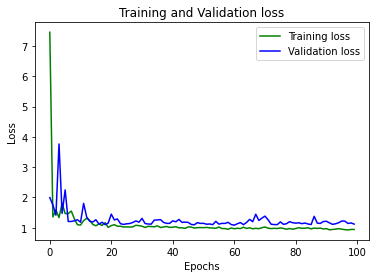

In [59]:
%matplotlib inline
NUM_EPOCHS=hyperparams['num_epochs']
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

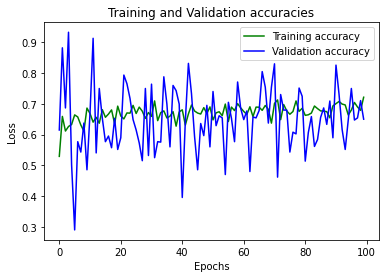

In [60]:
plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0,

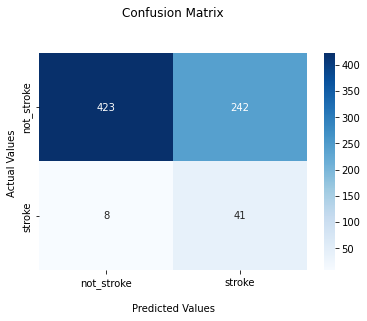

In [61]:
correct_not_stroke, wrong_not_stroke, correct_stroke, wrong_stroke = compute_confusion_matrix(
    val_predictions,
    val_labels
)
print(val_predictions)
print(val_labels)
cf_matrix = [
    [correct_not_stroke, wrong_stroke],
    [wrong_not_stroke, correct_stroke]
]
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['not_stroke','stroke'])
ax.yaxis.set_ticklabels(['not_stroke','stroke'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [62]:
precision_recall_fscore_support(val_labels, val_predictions, zero_division=0)

(array([0.98143852, 0.14487633]),
 array([0.63609023, 0.83673469]),
 array([0.77189781, 0.24698795]),
 array([665,  49]))

# Regression task

Cea mai mare diferenta dintre clasificare si regresie este aceea ca, in timp ce la clasificare noi incercam pentru un input sa prezicem o clasa in care acesta s-ar incadra (ceva fix), la regresie incercam sa prezicem o variabila continua care, pentru un set de date de intrare, reuseste din punct de vedere al valorii sa fie cat mai apropiata de acestea. 
Din punct de vedere al loss-ului, pentru regresie nu este de ajuns sa stim daca am reusit sau nu sa clasificam cu bine un input, ci trebuie sa stim valoarea deviatiei fata de valoarea actuala.

In [63]:
data_rows = []
for patient_data in rows:
  data_row = patient_data[2:10]
  data_row.append(patient_data[11])
  data_rows.append(data_row)
data_labels = [patient_data[10] for patient_data in rows]
train_data, validation_data, train_labels, validation_labels = train_test_split(data_rows, data_labels, test_size=0.2, random_state=42)

In [64]:
class BMIDataset(Dataset):
  def __init__(self, patient_data, patient_labels, transform=None):
    self.data = patient_data
    self.label = patient_labels

  def __getitem__(self, idx):
    patient_data = self.data[idx]
    patient_label = self.label[idx]

    patient_data_tensor = torch.tensor(patient_data)
    patient_label_tensor = torch.tensor([patient_label])
    return patient_data_tensor, patient_label_tensor

  def __len__(self):
    return len(self.data)

In [65]:
train_dataset = BMIDataset(patient_data=train_data, patient_labels=train_labels)
validation_dataset = BMIDataset(patient_data=validation_data, patient_labels=validation_labels)
print(len(validation_dataset))

714


In [66]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=64, shuffle=True)

In [67]:
class BMIPredictor(nn.Module):
  def __init__(self, 
                 input_size: int, 
                 hidden_size_1: int, 
                 hidden_size_2: int,
                 activation_fn: Callable):
    super().__init__()
    self.input_size = input_size
    self.hidden_size_1 = hidden_size_1
    self.hidden_size_2 = hidden_size_2
    self.layer_1 = nn.Linear(input_size, hidden_size_1)
    self.layer_2 = nn.Linear(hidden_size_1, hidden_size_2)
    self.output_layer = nn.Linear(hidden_size_2, 1)
    self.activation_fn = activation_fn

  def forward(self, x):
    h1 = self.activation_fn(self.layer_1(x))
    h2 = self.activation_fn(self.layer_2(h1))
    out = self.output_layer(h2)

    return out

In [68]:
def train_epoch_bmi(model, train_dataloader, loss_crt, optimizer, device):
    """
    model: Model object 
    train_dataloader: DataLoader over the training dataset
    loss_crt: loss function object
    optimizer: Optimizer object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch training loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels 
    """
    model.train()
    epoch_loss = 0.0
    num_batches = len(train_dataloader)
    predictions = []
    labels = []
    for idx, batch in tqdm(enumerate(train_dataloader)):
        # batch_size x 9, batch_size x 1
        batch_data, batch_labels = batch
        current_batch_size = batch_data.size(0)

        # move data to GPU
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        output = model(batch_data)

        loss = loss_crt(output, batch_labels)
        loss_scalar = loss.item()
        # print("  epoch %d, batch %d/%d, loss=%f" % (
        #     epoch_idx, idx, num_batches, loss_scalar
        # ))

        loss.backward()

        optimizer.step()
        model.zero_grad()

        epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss

def eval_epoch_bmi(model, val_dataloader, loss_crt, device):
    """
    model: Model object 
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch validation loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels 
    """
    model.eval()
    epoch_loss = 0.0
    num_batches = len(val_dataloader)
    predictions = []
    labels = []
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(val_dataloader)):
            # batch_size x 9, batch_size x 1
            batch_data, batch_labels = batch
            current_batch_size = batch_data.size(0)

            # move data to GPU
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            output = model(batch_data)

            loss = loss_crt(output, batch_labels)
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss

In [69]:
hyperparams = {
    'lr': 0.001,
    'num_epochs': 100,
    'hidden_size_1': 768,
    'hidden_size_2': 512,
    'activation_fn': nn.ReLU()
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_criterion = nn.MSELoss() # am schimbat functia de loss pentru regresie

model = BMIPredictor(
    input_size = 9, # folosesc 9 features (de la gender, la smoking_status, fara bmi)
    hidden_size_1 = hyperparams['hidden_size_1'],
    hidden_size_2 = hyperparams['hidden_size_2'],
    activation_fn = hyperparams['activation_fn']
)
model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=hyperparams['lr'])

train_losses, val_losses = [], []

for epoch_idx in range(hyperparams['num_epochs']):
    train_epoch_loss = train_epoch_bmi(
        model, 
        train_dataloader, 
        loss_criterion, 
        optimizer,
        device
    )
    val_epoch_loss = eval_epoch_bmi(
        model,
        validation_dataloader,
        loss_criterion,
        device
    )
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    
    print("epoch %d, train loss=%f, val loss=%f" % ( # am scos accuracy la regresie
        epoch_idx, 
        train_epoch_loss,
        val_epoch_loss
    ))

45it [00:00, 119.47it/s]
12it [00:00, 485.95it/s]


epoch 0, train loss=179.432733, val loss=114.627455


45it [00:00, 114.22it/s]
12it [00:00, 475.50it/s]


epoch 1, train loss=110.834452, val loss=101.879015


45it [00:00, 96.58it/s] 
12it [00:00, 433.66it/s]


epoch 2, train loss=89.739554, val loss=81.347730


45it [00:00, 108.95it/s]
12it [00:00, 481.22it/s]


epoch 3, train loss=80.428444, val loss=70.348029


45it [00:00, 112.45it/s]
12it [00:00, 456.96it/s]


epoch 4, train loss=69.967099, val loss=79.143880


45it [00:00, 114.04it/s]
12it [00:00, 363.95it/s]


epoch 5, train loss=71.169960, val loss=63.008653


45it [00:00, 118.51it/s]
12it [00:00, 491.52it/s]


epoch 6, train loss=63.577450, val loss=59.675068


45it [00:00, 117.89it/s]
12it [00:00, 522.57it/s]


epoch 7, train loss=62.811008, val loss=69.158932


45it [00:00, 108.21it/s]
12it [00:00, 499.63it/s]


epoch 8, train loss=63.603498, val loss=56.935009


45it [00:00, 106.70it/s]
12it [00:00, 462.13it/s]


epoch 9, train loss=64.764336, val loss=64.389195


45it [00:00, 113.39it/s]
12it [00:00, 510.84it/s]


epoch 10, train loss=65.718088, val loss=64.945996


45it [00:00, 116.84it/s]
12it [00:00, 428.90it/s]


epoch 11, train loss=64.524037, val loss=62.598981


45it [00:00, 114.50it/s]
12it [00:00, 466.11it/s]


epoch 12, train loss=64.503250, val loss=56.708862


45it [00:00, 114.55it/s]
12it [00:00, 441.66it/s]


epoch 13, train loss=62.559148, val loss=63.089897


45it [00:00, 118.90it/s]
12it [00:00, 510.80it/s]


epoch 14, train loss=63.227650, val loss=58.612271


45it [00:00, 109.74it/s]
12it [00:00, 421.67it/s]


epoch 15, train loss=59.997753, val loss=55.360977


45it [00:00, 90.77it/s]
12it [00:00, 428.45it/s]


epoch 16, train loss=63.127172, val loss=60.150852


45it [00:00, 79.09it/s]
12it [00:00, 435.83it/s]


epoch 17, train loss=60.620981, val loss=59.506375


45it [00:00, 75.24it/s]
12it [00:00, 502.20it/s]


epoch 18, train loss=59.050923, val loss=66.322661


45it [00:00, 77.22it/s]
12it [00:00, 450.94it/s]


epoch 19, train loss=61.863551, val loss=61.649697


45it [00:00, 82.65it/s]
12it [00:00, 466.38it/s]


epoch 20, train loss=59.180321, val loss=56.229961


45it [00:00, 87.93it/s]
12it [00:00, 512.40it/s]


epoch 21, train loss=59.835773, val loss=65.152806


45it [00:00, 93.22it/s]
12it [00:00, 456.98it/s]


epoch 22, train loss=61.228158, val loss=55.974358


45it [00:00, 89.11it/s]
12it [00:00, 451.85it/s]


epoch 23, train loss=59.483191, val loss=54.494772


45it [00:00, 85.33it/s]
12it [00:00, 456.59it/s]


epoch 24, train loss=58.487329, val loss=60.698078


45it [00:00, 84.17it/s]
12it [00:00, 466.42it/s]


epoch 25, train loss=57.846094, val loss=54.410205


45it [00:00, 84.40it/s]
12it [00:00, 423.93it/s]


epoch 26, train loss=60.084517, val loss=54.574223


45it [00:00, 87.19it/s]
12it [00:00, 544.40it/s]


epoch 27, train loss=59.688702, val loss=58.841545


45it [00:00, 87.68it/s]
12it [00:00, 532.17it/s]


epoch 28, train loss=62.282557, val loss=59.954631


45it [00:00, 87.52it/s]
12it [00:00, 491.45it/s]


epoch 29, train loss=59.884196, val loss=54.093019


45it [00:00, 86.32it/s]
12it [00:00, 521.45it/s]


epoch 30, train loss=58.075608, val loss=51.168563


45it [00:00, 84.77it/s]
12it [00:00, 326.95it/s]


epoch 31, train loss=58.086702, val loss=51.808111


45it [00:00, 84.95it/s]
12it [00:00, 522.94it/s]


epoch 32, train loss=58.510136, val loss=52.447063


45it [00:00, 89.00it/s]
12it [00:00, 530.91it/s]


epoch 33, train loss=58.371439, val loss=66.018807


45it [00:00, 90.45it/s]
12it [00:00, 444.20it/s]


epoch 34, train loss=58.455013, val loss=57.769471


45it [00:00, 81.76it/s]
12it [00:00, 437.30it/s]


epoch 35, train loss=58.041716, val loss=59.287130


45it [00:00, 84.01it/s]
12it [00:00, 445.41it/s]


epoch 36, train loss=57.714907, val loss=54.216130


45it [00:00, 83.70it/s]
12it [00:00, 431.53it/s]


epoch 37, train loss=55.951691, val loss=52.682482


45it [00:00, 89.63it/s]
12it [00:00, 483.88it/s]


epoch 38, train loss=60.829676, val loss=58.931364


45it [00:00, 80.49it/s]
12it [00:00, 450.45it/s]


epoch 39, train loss=56.545330, val loss=51.038757


45it [00:00, 83.19it/s]
12it [00:00, 426.63it/s]


epoch 40, train loss=55.871078, val loss=56.360345


45it [00:00, 87.11it/s]
12it [00:00, 505.10it/s]


epoch 41, train loss=59.567924, val loss=53.820829


45it [00:00, 93.85it/s]
12it [00:00, 468.49it/s]


epoch 42, train loss=56.493233, val loss=54.717483


45it [00:00, 93.51it/s]
12it [00:00, 527.28it/s]


epoch 43, train loss=55.026639, val loss=55.383248


45it [00:00, 92.85it/s]
12it [00:00, 435.25it/s]


epoch 44, train loss=57.667149, val loss=51.867394


45it [00:00, 85.05it/s]
12it [00:00, 413.66it/s]


epoch 45, train loss=54.369343, val loss=51.757937


45it [00:00, 84.08it/s]
12it [00:00, 429.14it/s]


epoch 46, train loss=55.333616, val loss=54.207824


45it [00:00, 87.20it/s]
12it [00:00, 516.13it/s]


epoch 47, train loss=55.053610, val loss=56.032230


45it [00:00, 89.53it/s]
12it [00:00, 538.48it/s]


epoch 48, train loss=55.407307, val loss=51.429171


45it [00:00, 94.07it/s]
12it [00:00, 540.32it/s]


epoch 49, train loss=54.173852, val loss=56.912735


45it [00:00, 90.47it/s]
12it [00:00, 504.45it/s]


epoch 50, train loss=56.739977, val loss=50.169157


45it [00:00, 88.24it/s]
12it [00:00, 447.97it/s]


epoch 51, train loss=54.413465, val loss=60.589732


45it [00:00, 86.41it/s]
12it [00:00, 513.55it/s]


epoch 52, train loss=58.448929, val loss=50.037104


45it [00:00, 88.61it/s]
12it [00:00, 569.86it/s]


epoch 53, train loss=55.611502, val loss=54.718545


45it [00:00, 88.76it/s]
12it [00:00, 536.99it/s]


epoch 54, train loss=57.880758, val loss=57.369923


45it [00:00, 86.10it/s]
12it [00:00, 426.34it/s]


epoch 55, train loss=58.792297, val loss=48.607935


45it [00:00, 87.41it/s]
12it [00:00, 482.85it/s]


epoch 56, train loss=54.259860, val loss=50.067797


45it [00:00, 85.08it/s]
12it [00:00, 487.57it/s]


epoch 57, train loss=53.835407, val loss=53.637455


45it [00:00, 86.76it/s]
12it [00:00, 373.03it/s]


epoch 58, train loss=52.991233, val loss=51.943874


45it [00:00, 79.82it/s]
12it [00:00, 446.11it/s]


epoch 59, train loss=53.589330, val loss=53.762863


45it [00:00, 82.75it/s]
12it [00:00, 330.36it/s]


epoch 60, train loss=54.010444, val loss=47.078290


45it [00:00, 89.06it/s]
12it [00:00, 499.07it/s]


epoch 61, train loss=54.482513, val loss=49.345186


45it [00:00, 88.93it/s]
12it [00:00, 524.19it/s]


epoch 62, train loss=54.239378, val loss=61.701108


45it [00:00, 91.33it/s]
12it [00:00, 521.14it/s]


epoch 63, train loss=53.087761, val loss=48.976144


45it [00:00, 91.26it/s]
12it [00:00, 521.44it/s]


epoch 64, train loss=54.431811, val loss=52.892492


45it [00:00, 91.72it/s]
12it [00:00, 521.13it/s]


epoch 65, train loss=52.734553, val loss=48.195906


45it [00:00, 90.64it/s]
12it [00:00, 496.57it/s]


epoch 66, train loss=51.632430, val loss=57.839253


45it [00:00, 91.83it/s]
12it [00:00, 460.98it/s]


epoch 67, train loss=54.681962, val loss=48.664960


45it [00:00, 88.75it/s]
12it [00:00, 515.77it/s]


epoch 68, train loss=52.154542, val loss=54.725236


45it [00:00, 85.98it/s]
12it [00:00, 432.79it/s]


epoch 69, train loss=51.662566, val loss=48.661451


45it [00:00, 86.88it/s]
12it [00:00, 531.09it/s]


epoch 70, train loss=53.326378, val loss=49.961422


45it [00:00, 88.88it/s]
12it [00:00, 547.56it/s]


epoch 71, train loss=51.140284, val loss=49.646549


45it [00:00, 88.31it/s]
12it [00:00, 531.52it/s]


epoch 72, train loss=51.968367, val loss=49.006298


45it [00:00, 89.37it/s]
12it [00:00, 506.43it/s]


epoch 73, train loss=51.428899, val loss=46.454287


45it [00:00, 88.37it/s]
12it [00:00, 538.90it/s]


epoch 74, train loss=53.163736, val loss=48.865252


45it [00:00, 83.85it/s]
12it [00:00, 433.69it/s]


epoch 75, train loss=52.632251, val loss=53.227482


45it [00:00, 87.16it/s]
12it [00:00, 500.38it/s]


epoch 76, train loss=53.912096, val loss=46.644991


45it [00:00, 86.61it/s]
12it [00:00, 500.16it/s]


epoch 77, train loss=51.118837, val loss=52.186639


45it [00:00, 81.21it/s]
12it [00:00, 394.01it/s]


epoch 78, train loss=52.160404, val loss=53.854716


45it [00:00, 78.55it/s]
12it [00:00, 441.18it/s]


epoch 79, train loss=56.735400, val loss=56.030163


45it [00:00, 78.56it/s]
12it [00:00, 498.84it/s]


epoch 80, train loss=54.068101, val loss=45.707746


45it [00:00, 81.58it/s]
12it [00:00, 433.26it/s]


epoch 81, train loss=49.896395, val loss=49.065700


45it [00:00, 84.13it/s]
12it [00:00, 457.09it/s]


epoch 82, train loss=50.159491, val loss=45.147904


45it [00:00, 84.51it/s]
12it [00:00, 445.61it/s]


epoch 83, train loss=51.450988, val loss=45.832010


45it [00:00, 83.57it/s]
12it [00:00, 443.20it/s]


epoch 84, train loss=51.745030, val loss=49.997830


45it [00:00, 82.44it/s]
12it [00:00, 391.71it/s]


epoch 85, train loss=50.116668, val loss=52.722857


45it [00:00, 81.84it/s]
12it [00:00, 470.64it/s]


epoch 86, train loss=50.285129, val loss=49.176062


45it [00:00, 84.97it/s]
12it [00:00, 462.74it/s]


epoch 87, train loss=50.518699, val loss=49.822062


45it [00:00, 85.06it/s]
12it [00:00, 380.92it/s]


epoch 88, train loss=51.235180, val loss=49.015327


45it [00:00, 85.43it/s]
12it [00:00, 495.93it/s]


epoch 89, train loss=53.999507, val loss=59.094735


45it [00:00, 78.92it/s]
12it [00:00, 513.43it/s]


epoch 90, train loss=55.400201, val loss=45.526134


45it [00:00, 82.32it/s]
12it [00:00, 401.60it/s]


epoch 91, train loss=50.513723, val loss=48.440174


45it [00:00, 83.91it/s]
12it [00:00, 411.14it/s]


epoch 92, train loss=50.033197, val loss=47.981006


45it [00:00, 87.12it/s]
12it [00:00, 502.17it/s]


epoch 93, train loss=50.909531, val loss=47.581305


45it [00:00, 78.48it/s]
12it [00:00, 345.67it/s]


epoch 94, train loss=50.945567, val loss=50.281117


45it [00:00, 77.34it/s]
12it [00:00, 476.06it/s]


epoch 95, train loss=49.809730, val loss=49.506618


45it [00:00, 80.28it/s]
12it [00:00, 459.39it/s]


epoch 96, train loss=50.853318, val loss=52.217625


45it [00:00, 82.22it/s]
12it [00:00, 386.83it/s]


epoch 97, train loss=51.245197, val loss=46.200195


45it [00:00, 81.54it/s]
12it [00:00, 355.19it/s]


epoch 98, train loss=48.691408, val loss=51.316857


45it [00:00, 81.87it/s]
12it [00:00, 473.43it/s]

epoch 99, train loss=51.336500, val loss=48.696995


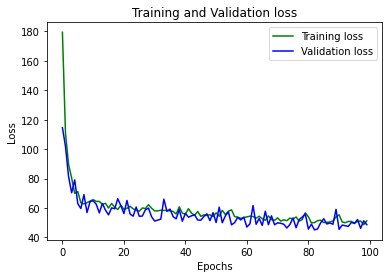

In [70]:
%matplotlib inline
NUM_EPOCHS=hyperparams['num_epochs']
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()